# Auswertung der Messungen

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import scipy.stats as stats
import math

In [2]:
gen_mapping = {
    "ibmq": "IBM Quantencomputer",
    "ql_qrng_cond": "Quintessence Labs QRNG (conditioned)",
    "idq_qrng": "ID Quantique QRNG",
    "lcg_mod2147483647_a16807_c0": "Linearer Kongruenzgenerator ($mod=2^{31}-1$, $a=16807$, $c=0$)",
    "urandom_empty": "Linux' /dev/urandom (ausgeschöpfter Entropiepool)",
    "lcg_mod16777216_a189_c1": "Linearer Kongruenzgenerator ($mod=2^{24}$, $a=189$, $c=1$)",
    "urandom": "Linux' /dev/urandom (voller Entropiepool)",
    "lcg_mod2147483647_a48271_c0": "Linearer Kongruenzgenerator ($mod=2^{31}-1$, $a=48271$, $c=0$)",
    "ql_qrng_cond_quantropi": "Quintessence Labs QRNG (conditioned + Quantropi)",
    "lcg_mod16777216_a315_c1": "Linearer Kongruenzgenerator ($mod=2^{24}$, $a=315$, $c=1$)",
    "ql_qrng_raw": "Quintessence Labs QRNG (raw)",
}

## Ent

In [3]:
path = "./results/ent"

onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

print(onlyfiles)

dfs = {}


number_of_categories = 256

for filename in onlyfiles:
    with open(join(path, filename), "r") as file:
        contents = file.read().split("\n")
        results = contents[:2]
        df = pd.DataFrame([line.split(",") for line in results])
        df.drop(columns=[0], inplace=True)

        # Calculate chi_2 distribution based on observed values
        results = contents[3:]
        df_chi = pd.DataFrame([line.split(",") for line in results])
        df_chi.drop(columns=[0], inplace=True)
        filesize = int(df[1].to_list()[1])
        expected_value = int(filesize / number_of_categories)

        observed = df_chi[2].to_list()
        expected = np.full(256, expected_value)

        (chi_2, p_value) = stats.chisquare(observed, expected)
        # Replace chi_2
        df[3][1] = "{:10.6f}".format(chi_2)
        # Add p-value
        df[7] = ["p-value", "{:10.6f}".format(p_value)]

        # Calculate deviation from pi
        monte_carlo_pi = float(df[5].to_list()[1])
        pi_dev_percent = (monte_carlo_pi / math.pi) - 1
        pi_dev = monte_carlo_pi - math.pi
        df[8] = [
            "Monte-Carlo-Pi-%",
            "({:.2f}\%) {:.6f}".format(pi_dev_percent * 100, pi_dev),
        ]
        print(df)
        dfs[filename.split(".")[0]] = df


['lcg_mod16777216_a315_c1.csv', 'ql_qrng_raw.csv', 'ql_qrng_cond_quantropi.csv', 'ql_qrng_cond.csv', 'ibmq.csv', 'idq_qrng.csv', 'urandom_empty.csv', 'lcg_mod16777216_a189_c1.csv', 'lcg_mod2147483647_a16807_c0.csv', 'lcg_mod2147483647_a48271_c0.csv', 'urandom.csv']
             1         2           3           4               5  \
0   File-bytes   Entropy  Chi-square        Mean  Monte-Carlo-Pi   
1  10737418240  8.000000    0.000000  127.500000        3.141374   

                    6           7                    8  
0  Serial-Correlation     p-value     Monte-Carlo-Pi-%  
1            0.003157    1.000000  (-0.01\%) -0.000219  
             1         2                   3          4               5  \
0   File-bytes   Entropy          Chi-square       Mean  Monte-Carlo-Pi   
1  10737418240  7.380125  14073326431.082235  79.501254        3.961493   

                    6           7                   8  
0  Serial-Correlation     p-value    Monte-Carlo-Pi-%  
1           -0.44803

In [4]:
order = {
    "File-bytes": 1,
    "Entropy": 2,
    "Mean": 3,
    "Chi-square": 4,
    "p-value": 5,
    "Monte-Carlo-Pi": 6,
    "Monte-Carlo-Pi-%": 7,
    "Serial-Correlation": 8,
}

test_mapping = {
    "File-bytes": "Dateigröße (Bytes)",
    "Entropy": "Entropie pro Byte",
    "Mean": "Arithmetisches Mittel",
    "Chi-square": "$\chi^2$",
    "p-value": "$\chi^2$ p-Wert",
    "Monte-Carlo-Pi": "Monte Carlo $\pi$",
    "Monte-Carlo-Pi-%": "Monte Carlo $\pi$ Abweichung",
    "Serial-Correlation": "Autokorrelationskoeffizient",
}

dfs_ent = {}

for key in dfs.keys():
    df = dfs[key]
    df = df.transpose()
    df["order"] = df[0].apply(lambda x: order[x])
    df.sort_values(by="order", inplace=True)
    df.drop(columns=["order"], inplace=True)
    df[0] = df[0].apply(lambda x: test_mapping[x])
    df[1] = df[1].apply(lambda x: x.replace(".", ","))
    df.columns = ["Eigenschaft", "Wert"]
    dfs_ent[key] = df


### Dataframe als Latex Tabelle

In [5]:
for key in dfs_ent.keys():
    df = dfs_ent[key]
    styler = df.style

    styler.format_index(
        escape="latex", axis=1
    ).format_index(escape="latex", axis=0).hide(level=0, axis=0)

    print(
        styler.to_latex(
            hrules=True,
            position="H",
            position_float="centering",
            column_format="lr",
            caption=f"ENT Testergebnisse: {gen_mapping[key]}",
            label=f"tab:ent:{key}",
        )
    )

\begin{table}[H]
\centering
\caption{ENT Testergebnisse: Linearer Kongruenzgenerator ($mod=2^{24}$, $a=315$, $c=1$)}
\label{tab:ent:lcg_mod16777216_a315_c1}
\begin{tabular}{lr}
\toprule
Eigenschaft & Wert \\
\midrule
Dateigröße (Bytes) & 10737418240 \\
Entropie pro Byte & 8,000000 \\
Arithmetisches Mittel & 127,500000 \\
$\chi^2$ &   0,000000 \\
$\chi^2$ p-Wert &   1,000000 \\
Monte Carlo $\pi$ & 3,141374 \\
Monte Carlo $\pi$ Abweichung & (-0,01\%) -0,000219 \\
Autokorrelationskoeffizient & 0,003157 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{ENT Testergebnisse: Quintessence Labs QRNG (raw)}
\label{tab:ent:ql_qrng_raw}
\begin{tabular}{lr}
\toprule
Eigenschaft & Wert \\
\midrule
Dateigröße (Bytes) & 10737418240 \\
Entropie pro Byte & 7,380125 \\
Arithmetisches Mittel & 79,501254 \\
$\chi^2$ & 14073326431,082235 \\
$\chi^2$ p-Wert &   0,000000 \\
Monte Carlo $\pi$ & 3,961493 \\
Monte Carlo $\pi$ Abweichung & (26,10\%) 0,819900 \\
Autokorrelationskoeffiz

## Dieharder

In [6]:
path = "./results/dieharder"

onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

print(onlyfiles)

dfs = {}

for filename in onlyfiles:
    with open(join(path, filename), "r") as file:
        results = file.read()
        # Remove first 6 lines
        results = results.split("\n")[6:]
        # Remove whitespace
        results = [line.replace(" ", "") for line in results]
        # Filter lines starting with "#"
        results = list(filter(lambda x: x[0] != "#", results))
        # Filter lines starting with "Preparing to run"
        results = list(filter(lambda x: not x.startswith("Preparingtorun"), results))
        # Replace underscores with spaces
        results = [line.replace("_", " ") for line in results]
        # Read result as dataframe
        df = pd.DataFrame([line.split("|") for line in results])
        # Replace header
        new_header = df.iloc[0]
        df = df[1:]
        df.columns = new_header
        # Convert data types
        df["ntup"] = pd.to_numeric(df["ntup"])
        df["tsamples"] = pd.to_numeric(df["tsamples"])
        df["psamples"] = pd.to_numeric(df["psamples"])
        df["p-value"] = pd.to_numeric(df["p-value"])

        dfs[filename.split(".")[0]] = df


['ibmq.txt', 'ql_qrng_cond.txt', 'idq_qrng.txt', 'lcg_mod2147483647_a16807_c0.txt', 'urandom_empty.txt', 'lcg_mod16777216_a189_c1.txt', 'urandom.txt', 'lcg_mod2147483647_a48271_c0.txt', 'ql_qrng_cond_quantropi.txt', 'lcg_mod16777216_a315_c1.txt', 'ql_qrng_raw.txt']


### Darstellung gleicher Tests mit unterschiedlichen Parametern

Wenn der gleiche Test mit unterschiedlichen Parametern ausgeführt wird, werden die Ergebnisse akkumuliert, da sonst die Tabellen viel zu lang werden

In [7]:
dfs_dieharder = {}

for key in dfs.keys():
    df = dfs[key]
    unique_tests = df["test name"].unique()

    acc = []

    for test in unique_tests:
        part_df = df.loc[df["test name"] == test]
        num_rows = part_df.shape[0]

        # Is there more than one variant of a test?
        if num_rows > 1:
            # Get min and max values per column
            ntup_min = part_df["ntup"].min()
            ntup_max = part_df["ntup"].max()
            tsamples_min = part_df["tsamples"].min()
            tsamples_max = part_df["tsamples"].max()
            psamples_min = part_df["psamples"].min()
            psamples_max = part_df["psamples"].max()
            # Get mean for p-values
            p_mean = part_df["p-value"].mean()

            # Count failed, weak and passed tests
            assessments = part_df["Assessment"].to_list()
            failed_count = assessments.count("FAILED")
            weak_count = assessments.count("WEAK")
            passed_count = assessments.count("PASSED")

            assessment_str = []

            if failed_count > 0:
                assessment_str.append(f"{failed_count}/{num_rows} FAILED")

            if weak_count > 0:
                assessment_str.append(f"{weak_count}/{num_rows} WEAK")

            if passed_count > 0:
                assessment_str.append(f"{passed_count}/{num_rows} PASSED")

            ntup_str = ntup_min if ntup_min == ntup_max else f"{ntup_min}...{ntup_max}"
            tsamples_str = tsamples_min if tsamples_min == tsamples_max else f"{tsamples_min}...{tsamples_max}"
            psamples_str = psamples_min if psamples_min == psamples_max else f"{psamples_min}...{psamples_max}"

            row = [
                test,
                ntup_str,
                tsamples_str,
                psamples_str,
                p_mean,
                "\makecell[tr]{" + "\\\\".join(assessment_str) + "}",
            ]
            acc.append(row)
        else:
            acc.append(part_df.iloc[0].to_list())
    
    df_acc = pd.DataFrame(acc)
    df_acc.columns = ["Test", "ntup", "tsamples", "psamples", "p-Wert", "Ergebnis"]
    dfs_dieharder[key] = df_acc


### Dataframe als Latex Tabelle

In [8]:
name_mapping = {
    "diehard birthdays": "\enquote{Birthdays} Test",
    "diehard operm5": "Overlapping 5-Permutations Test",
    "diehard rank 32x32": "32x32 Binary Rank Test",
    "diehard rank 6x8": "6x8 Binary Rank Test",
    "diehard bitstream": "Bitstream Test",
    "diehard opso": "Overlapping Pairs Sparse Occupance (OPSO) Test",
    "diehard oqso": "Overlapping Quadruples Sparce Occupance (OQSO) Test",
    # "diehard opso": "OPSO Test",
    # "diehard oqso": "OQSO Test",
    "diehard dna": "DNA Test",
    "diehard count 1s str": "Count the 1s Test (Stream)",
    "diehard count 1s byt": "Count the 1s Test (Byte)",
    "diehard parking lot": "Parking Lot Test",
    "diehard 2dsphere": "Minimum Distance (2D Circle) Test",
    "diehard 3dsphere": "Minimum Distance (3D Sphere) Test",
    "diehard squeeze": "Squeeze Test",
    "diehard sums": "Sums Test",
    "diehard runs": "Runs Test",
    "diehard craps": "Craps Test",
    "marsaglia tsang gcd": "Marsaglia and Tsang GCD Test",
    "sts monobit": "STS Monobit Test",
    "sts runs": "STS Runs Test",
    "sts serial": "STS Serial Test",
    "rgb bitdist": "RGB Bit Distribution Test",
    "rgb minimum distance": "RGB Generalized Minimum Distance Test",
    "rgb permutations": "RGB Permutations Test",
    "rgb lagged sum": "RGB Lagged Sums Test",
    "rgb kstest test": "RGB Kolmogorov-Smirnov Test",
    "dab bytedistrib": "DAB Byte Distribution Test",
    "dab dct": "DCT (Frequency Analysis) Test",
    "dab filltree": "DAB Fill Tree Test",
    "dab filltree2": "DAB Fill Tree 2 Test",
    "dab monobit2": "DAB Monobit 2 Test",
}

for key in dfs_dieharder.keys():
    df = dfs_dieharder[key]
    df["Test"] = df["Test"].apply(lambda x: name_mapping[x])
    df.drop("ntup", axis=1, inplace=True)
    df.drop("tsamples", axis=1, inplace=True)
    df.drop("psamples", axis=1, inplace=True)

    styler = df.style

    styler.format(subset="p-Wert", precision=6, decimal=",").format_index(
        escape="latex", axis=1
    ).format_index(escape="latex", axis=0).hide(level=0, axis=0)

    print(
        styler.to_latex(
            hrules=True,
            position="H",
            position_float="centering",
            column_format="lrr",
            caption=f"Dieharder Testergebnisse: {gen_mapping[key]}",
            label=f"tab:dieharder:{key}",
        )
    )


\begin{table}[H]
\centering
\caption{Dieharder Testergebnisse: IBM Quantencomputer}
\label{tab:dieharder:ibmq}
\begin{tabular}{lrr}
\toprule
Test & p-Wert & Ergebnis \\
\midrule
\enquote{Birthdays} Test & 0,879422 & PASSED \\
Overlapping 5-Permutations Test & 0,000000 & FAILED \\
32x32 Binary Rank Test & 0,808558 & PASSED \\
6x8 Binary Rank Test & 0,000000 & FAILED \\
Bitstream Test & 0,000000 & FAILED \\
Overlapping Pairs Sparse Occupance (OPSO) Test & 0,000000 & FAILED \\
Overlapping Quadruples Sparce Occupance (OQSO) Test & 0,000000 & FAILED \\
DNA Test & 0,000000 & FAILED \\
Count the 1s Test (Stream) & 0,000000 & FAILED \\
Count the 1s Test (Byte) & 0,000000 & FAILED \\
Parking Lot Test & 0,000000 & FAILED \\
Minimum Distance (2D Circle) Test & 0,903609 & PASSED \\
Minimum Distance (3D Sphere) Test & 0,677671 & PASSED \\
Squeeze Test & 0,000000 & FAILED \\
Sums Test & 0,001973 & WEAK \\
Runs Test & 0,745420 & \makecell[tr]{2/2 PASSED} \\
Craps Test & 0,000000 & \makecell[tr]{2/2 F

## NIST SP 800-22

In [9]:
path = "./results/nist"

onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

print(onlyfiles)

dfs = {}

order = {
    "Frequency": 1,
    "BlockFrequency": 2,
    "Runs": 3,
    "LongestRun": 4,
    "Rank": 5,
    "FFT": 6,
    "NonOverlappingTemplate": 7,
    "OverlappingTemplate": 8,
    "Universal": 9,
    "LinearComplexity": 10,
    "Serial": 11,
    "ApproximateEntropy": 12,
    "CumulativeSums": 13,
    "RandomExcursions": 14,
    "RandomExcursionsVariant": 15,
}

for filename in onlyfiles:
    with open(join(path, filename), "r") as file:
        results = file.read()
        # Take lines 8 to 195
        results = results.split("\n")[7:195]
        # Did the test fail?
        results = [line + (" FAILED" if "*" in line or "-" in line else " PASSED") for line in results]
        # Remove "*"
        results = [line.replace("*", "") for line in results]
        # Remove multiple spaces
        results = [" ".join(line.split()) for line in results]

        df = pd.DataFrame([line.split(" ") for line in results])
        df.columns = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "p-value", "proportion", "test name", "Assessment"]
        
        # Add number of successful tests and total number of tests
        df["successful count"] = df["proportion"].str.split("/").str[0]
        df["total count"] = df["proportion"].str.split("/").str[1]
        # Custom order
        df['order'] = df['test name'].apply(lambda x: order[x])
        df = df.sort_values(by=['order'])
        df.drop(columns=["order"], inplace=True)

        # Convert data types
        for i in range(1, 11):
            df[f"C{i}"] = pd.to_numeric(df[f"C{i}"])
        df["p-value"] = pd.to_numeric(df["p-value"], errors="coerce")
        df["successful count"] = pd.to_numeric(df["successful count"], errors="coerce")
        df["total count"] = pd.to_numeric(df["total count"], errors="coerce")

        dfs[filename.split(".")[0]] = df



['ibmq.txt', 'ql_qrng_cond.txt', 'idq_qrng.txt', 'lcg_mod2147483647_a16807_c0.txt', 'urandom_empty.txt', 'lcg_mod16777216_a189_c1.txt', 'urandom.txt', 'lcg_mod2147483647_a48271_c0.txt', 'ql_qrng_cond_quantropi.txt', 'lcg_mod16777216_a315_c1.txt', 'ql_qrng_raw.txt']


### Darstellung gleicher Tests mit unterschiedlichen Parametern

Wenn der gleiche Test mit unterschiedlichen Parametern ausgeführt wird, werden die Ergebnisse akkumuliert, da sonst die Tabellen viel zu lang werden

In [10]:
dfs_nist = {}

for key in dfs.keys():
    df = dfs[key]
    unique_tests = df["test name"].unique()

    acc = []

    for test in unique_tests:
        part_df = df.loc[df["test name"] == test]
        num_rows = part_df.shape[0]

        # Is there more than one variant of a test?
        if num_rows > 1:
            row = []
            for i in range(1, 11):
                min_c = part_df[f"C{i}"].min()
                max_c = part_df[f"C{i}"].max()
                row.append(f"{min_c}...{max_c}" if min_c != max_c else f"{min_c}")

            min_proportion = part_df["successful count"].min()
            max_proportion = part_df["successful count"].max()
            total_count = part_df["total count"].max()

            assessments = part_df["Assessment"].to_list()
            failed_count = assessments.count("FAILED")
            passed_count = assessments.count("PASSED")

            assessment_str = []

            if failed_count > 0:
                assessment_str.append(f"{failed_count}/{num_rows} FAILED")

            if passed_count > 0:
                assessment_str.append(f"{passed_count}/{num_rows} PASSED")

            row.append(part_df["p-value"].mean())
            row.append(f"{min_proportion}...{max_proportion}/{total_count}" if min_proportion != max_proportion else f"{min_proportion}/{total_count}")
            row.append(test)
            row.append("\makecell[tr]{" + "\\\\".join(assessment_str) + "}",)
            row.append(part_df["successful count"].to_list())
            row.append(total_count)
            acc.append(row)
        else:
            acc.append(part_df.iloc[0].to_list())

    df_acc = pd.DataFrame(acc)
    df_acc.columns = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "p-Wert", "Verhältnis", "Test", "Ergebnis", "successful count", "total count"]
    dfs_nist[key] = df_acc


### NIST Verhältnisse als Plot

Fast jeder Test wird 1073 Mal durchgeführt. Das Verhältnis bestandener Tests wird berechnet und sollte innerhalb des Konfidenzintervalls liegen.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import locale
import math

locale.setlocale(locale.LC_NUMERIC, "de_DE")

plt.rcParams['axes.formatter.use_locale'] = True
plt.rcParams["figure.figsize"] = (6,2.5)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Source Sans Pro"
plt.rcParams["mathtext.fontset"] = "cm"

Da das im NIST Dokument angegebene Intervall nur für $m=1000$ gilt, wird das Konfidenzintervall hier neu berechnet

Berechnung des Konfidenzintervalls\
$\hat{p} \pm 3\sqrt{\frac{\hat{p}(1-\hat{p})}{m}}$\
$\hat{p} = 1 - \alpha = 99\%$

In [12]:
alpha = 0.01
p_hat = 1 - alpha
m = 1073

acceptable = 3 * math.sqrt(p_hat * (1 - p_hat) / m)

upper = p_hat + acceptable
lower = p_hat - acceptable

print(acceptable)

0.009112530418298619


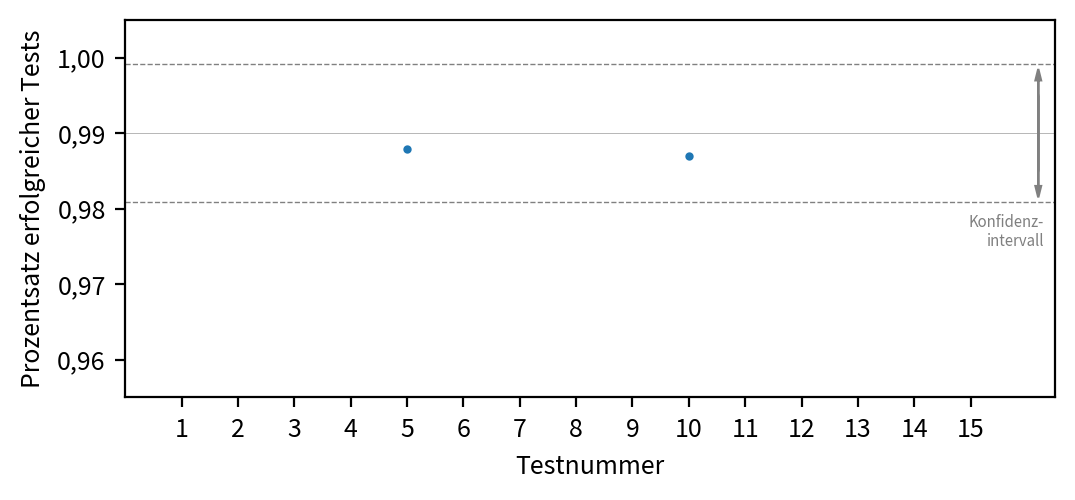

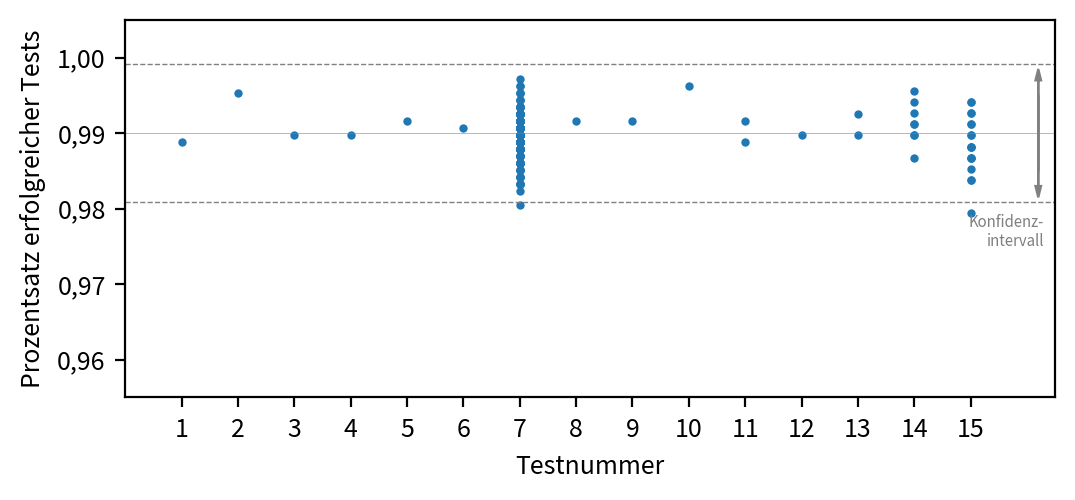

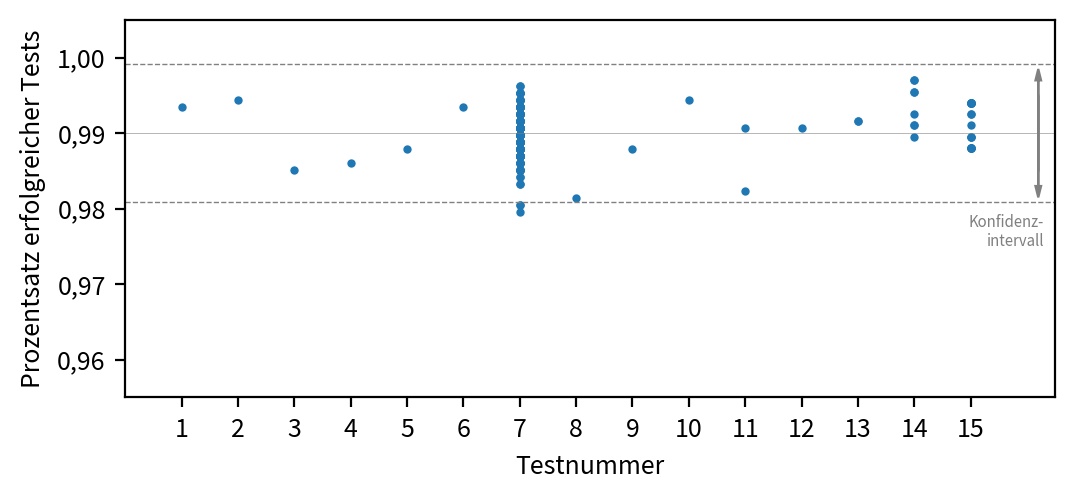

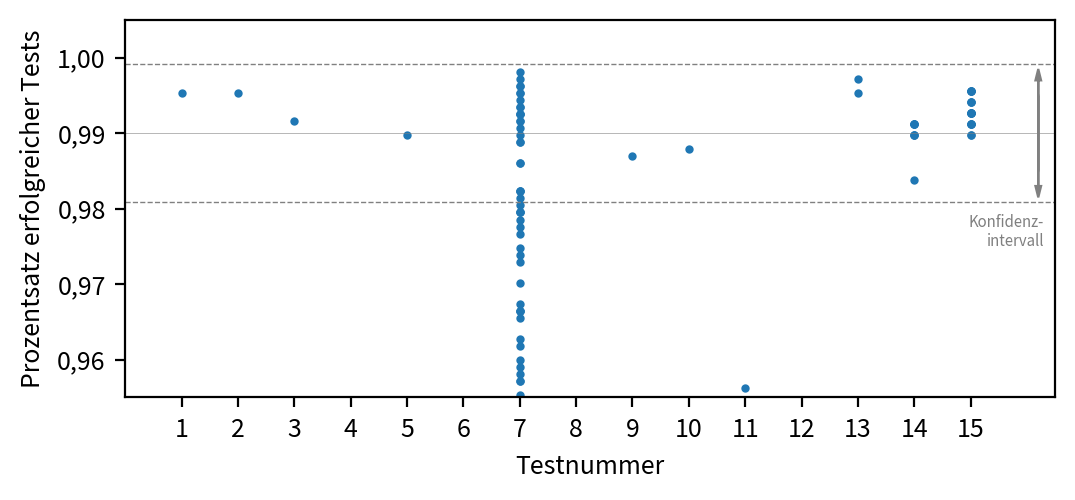

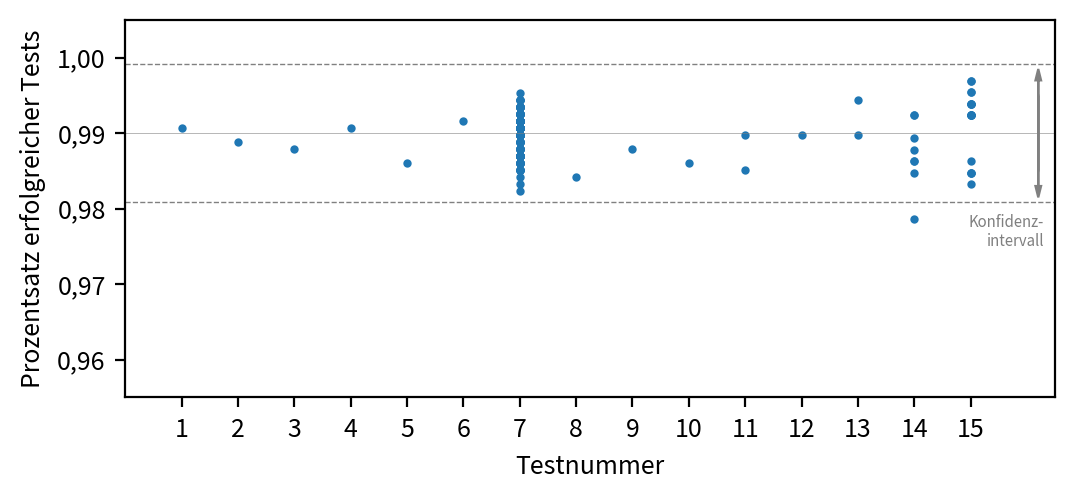

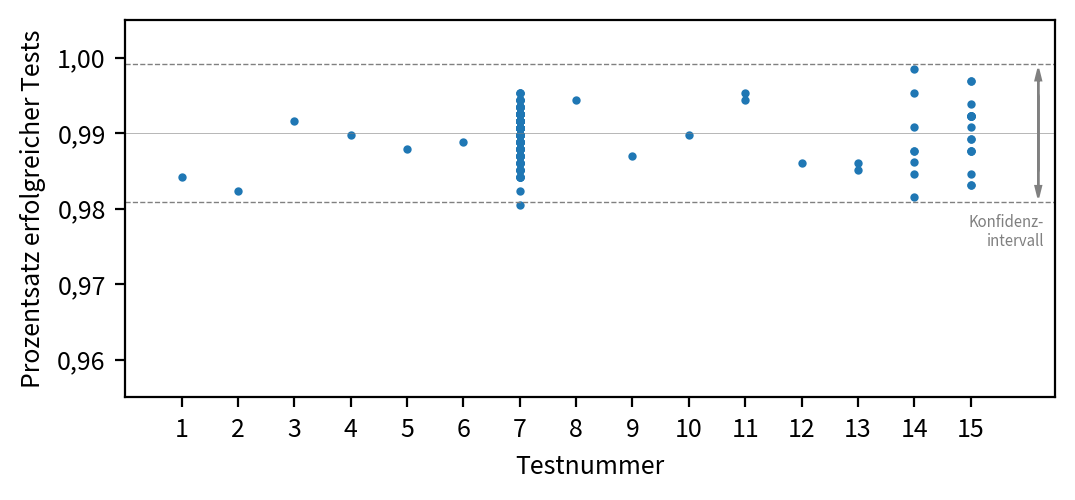

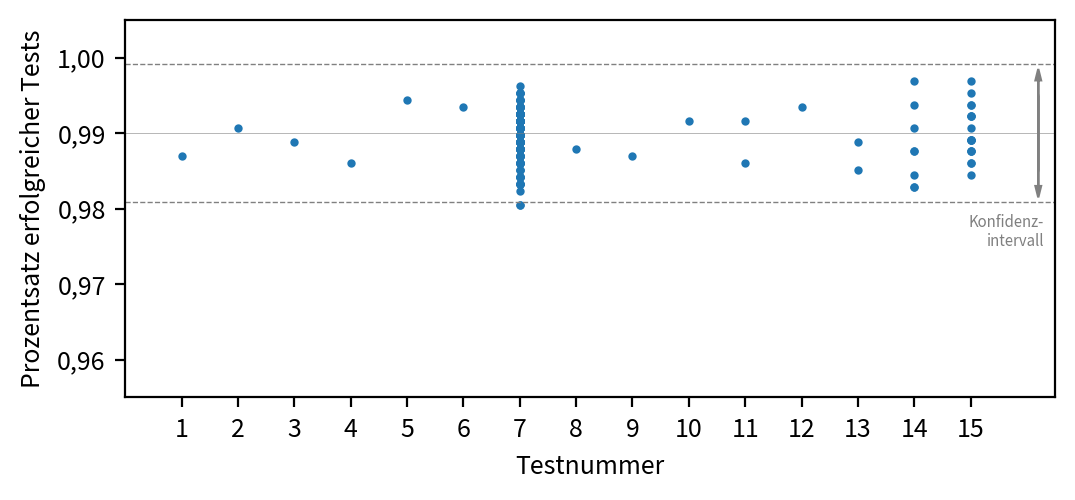

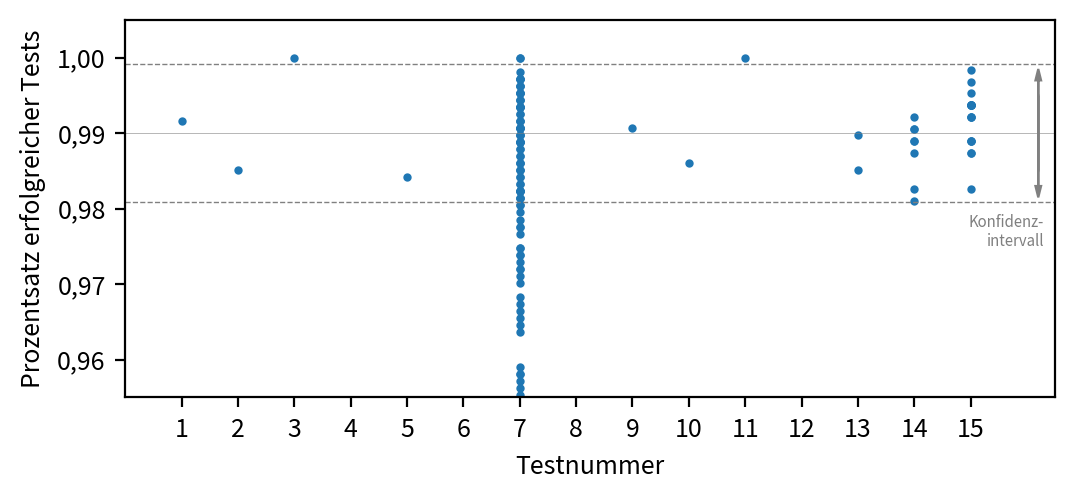

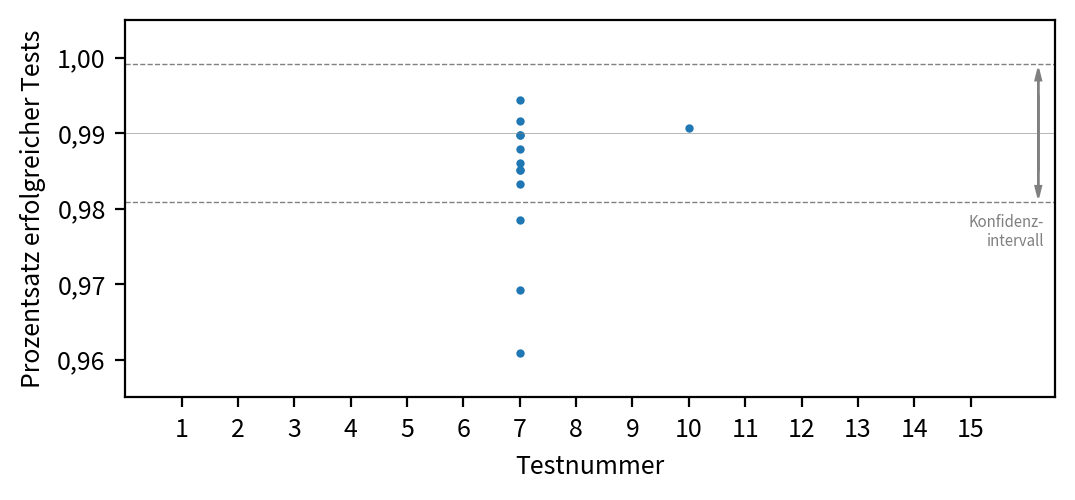

In [13]:
for key in dfs_nist:
    test_df = dfs_nist[key]

    x = []
    y = []

    for i in range(1, 16):
        counts = test_df.iloc[[i - 1]]["successful count"].iloc[0]
        ref = test_df.iloc[[i - 1]]["total count"].iloc[0]
        if isinstance(counts, list):
            for count in counts:
                x.append(i)
                y.append(count / ref)
        else:
            x.append(i)
            y.append(counts / ref)

    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(1, 16, 1))
    ax.set_yticks(np.arange(0.96, 1, 0.01))
    ax.set_xlim([0, 16.5])
    ax.set_ylim([0.955, 1.005])
    ax.set_ylabel("Prozentsatz erfolgreicher Tests")
    ax.set_xlabel("Testnummer")
    ax.plot(x, y, ".", markersize=4)
    ax.hlines([lower, upper], 0, 16.5, colors="grey", linestyles="dashed", linewidth=0.5)
    ax.hlines([p_hat], 0, 17, colors="grey", linewidth=0.2)
    ax.arrow(16.2, 0.985, 0, 0.0135, color="grey", head_width=0.1, head_length=0.0015, length_includes_head=True, linewidth=0.8)
    ax.arrow(16.2, 0.995, 0, -0.0135, color="grey", head_width=0.1, head_length=0.0015, length_includes_head=True, linewidth=0.8)
    ax.annotate("Konfidenz-\nintervall", (16.3, 0.975), ha='right', color="grey", fontsize=6)

    plt.savefig(f"figures/nist_proportion_{key}.png" , dpi=400, bbox_inches='tight', transparent=True)
    plt.show()

### Dataframe als Latex Tabelle

In [14]:
name_mapping = {
    "Frequency": "Frequency (Monobit) Test",
    "BlockFrequency": "Frequency Test within a Block",
    "Runs": "Runs Test",
    "LongestRun": "Test for the Longest Run of Ones in a Block",
    "Rank": "Binary Matrix Rank Test",
    "FFT": "Discrete Fourier Transform (Spectral) Test",
    "NonOverlappingTemplate": "Non-Overlapping Template Matching Test",
    "OverlappingTemplate": "Overlapping Template Matching Test",
    "Universal": "Maurer's \enquote{Universal Statistical} Test",
    "LinearComplexity": "Linear Complexity Test",
    "Serial": "Serial Test",
    "ApproximateEntropy": "Approximate Entropy Test",
    "CumulativeSums": "Cumulative Sums (Cusums) Test",
    "RandomExcursions": "Random Excursions Test",
    "RandomExcursionsVariant": "Random Excursions Variant Test",
}

for key in dfs_nist.keys():
    df = dfs_nist[key]
    df["Test"] = df["Test"].apply(lambda x: name_mapping[x])
    for i in range(1, 11):
        df.drop(f"C{i}", axis=1, inplace=True)
    df.drop("successful count", axis=1, inplace=True)
    df.drop("total count", axis=1, inplace=True)
    df.drop("Verhältnis", axis=1, inplace=True)
    # Rearrange columns
    df = df[["Test", "p-Wert", "Ergebnis"]]

    styler = df.style

    styler.format(subset="p-Wert", precision=6, decimal=",").format_index(
        escape="latex", axis=1
    ).format_index(escape="latex", axis=0).hide(level=0, axis=0)

    print(
        styler.to_latex(
            hrules=True,
            position_float="centering",
            position="H",
            column_format="lrr",
            caption=f"NIST Testergebnisse: {gen_mapping[key]}",
            label=f"tab:nist:{key}",
        )
    )


\begin{table}[H]
\centering
\caption{NIST Testergebnisse: IBM Quantencomputer}
\label{tab:nist:ibmq}
\begin{tabular}{lrr}
\toprule
Test & p-Wert & Ergebnis \\
\midrule
Frequency (Monobit) Test & 0,000000 & FAILED \\
Frequency Test within a Block & 0,000000 & FAILED \\
Runs Test & 0,000000 & FAILED \\
Test for the Longest Run of Ones in a Block & 0,000000 & FAILED \\
Binary Matrix Rank Test & 0,635173 & PASSED \\
Discrete Fourier Transform (Spectral) Test & 0,000000 & FAILED \\
Non-Overlapping Template Matching Test & 0,000000 & \makecell[tr]{148/148 FAILED} \\
Overlapping Template Matching Test & 0,000000 & FAILED \\
Maurer's \enquote{Universal Statistical} Test & 0,000000 & FAILED \\
Linear Complexity Test & 0,101730 & PASSED \\
Serial Test & 0,000000 & \makecell[tr]{2/2 FAILED} \\
Approximate Entropy Test & 0,000000 & FAILED \\
Cumulative Sums (Cusums) Test & 0,000000 & \makecell[tr]{2/2 FAILED} \\
Random Excursions Test & nan & \makecell[tr]{8/8 FAILED} \\
Random Excursions Variant 